# Model 0.04 - Rescuer
 - analyse count of rescuer and compare training and test data
 - training and test data do not share any rescuers (will final test data?)
 - Due to no shared rescuers, decision to use counts (not normalised)
 - significant score improvement (0.354 --> 0.381)

In [124]:
import ml_metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [2]:
rnd = 42  # random state for scoring consistency

## Importing the data

In [3]:
df_train = pd.read_csv("../input/train/train.csv", index_col="PetID")
df_test = pd.read_csv("../input/test/test.csv", index_col="PetID")
df_breeds = pd.read_csv("../input/breed_labels.csv")
df_colors = pd.read_csv("../input/color_labels.csv")

In [4]:
colors = df_colors['ColorID']
breeds = df_breeds['BreedID']

## Analysing RescuerID

In [19]:
# count of distinct rescuers
len(df_train['RescuerID'].unique())

5595

In [61]:
# top rescuers (training data)
cnt1 = Counter(df_train['RescuerID'])
cnt1.most_common(10)

[('fa90fa5b1ee11c86938398b60abc32cb', 459),
 ('aa66486163b6cbc25ea62a34b11c9b91', 315),
 ('c00756f2bdd8fa88fc9f07a8309f7d5d', 231),
 ('b53c34474d9e24574bcec6a3d3306a0d', 228),
 ('ee2747ce26468ec44c7194e7d1d9dad9', 156),
 ('95481e953f8aed9ec3d16fc4509537e8', 134),
 ('b770bac0ca797cf1433c48a35d30c4cb', 111),
 ('a042471e0f43f2cf707104a1a138a7df', 95),
 ('fd970cc91d06d82eebf046340137b272', 93),
 ('7ed6d84e2e6879245e55447aee39c328', 85)]

In [60]:
# top rescuers (testing data)
cnt2 = Counter(df_test['RescuerID'])
cnt2.most_common(10)

[('4475f31553f0170229455e3c5645644f', 146),
 ('0a1ff8402419c5fc2987085711928887', 81),
 ('a784899699776c1e71d9bc51bf45459c', 74),
 ('644449224c6fd82a2dbbc6155ade9aed', 67),
 ('0b19581048b55d65caa01d1d62b93330', 64),
 ('e6a42485af66a5fbf3f21fc8242fbf57', 62),
 ('3e4eeabc665cc918d6c9b14dc1310542', 59),
 ('fb4551428a0ed6c565e6b21da9ac4085', 54),
 ('0b363aae92ab0ecf6130d4b9d3d874e3', 49),
 ('ef6be63a03b751a7ffe0c3296b2494a9', 48)]

In [38]:
# common rescuers # NONE!!!
cnt1.keys() & cnt2.keys()  

set()

In [41]:
# top rescuers (combined test and training data)
df_combined = pd.concat([df_test, df_train], sort=False)
cnt3 = Counter(df_combined['RescuerID'])
cnt3.most_common(10)

[('fa90fa5b1ee11c86938398b60abc32cb', 459),
 ('aa66486163b6cbc25ea62a34b11c9b91', 315),
 ('c00756f2bdd8fa88fc9f07a8309f7d5d', 231),
 ('b53c34474d9e24574bcec6a3d3306a0d', 228),
 ('ee2747ce26468ec44c7194e7d1d9dad9', 156),
 ('4475f31553f0170229455e3c5645644f', 146),
 ('95481e953f8aed9ec3d16fc4509537e8', 134),
 ('b770bac0ca797cf1433c48a35d30c4cb', 111),
 ('a042471e0f43f2cf707104a1a138a7df', 95),
 ('fd970cc91d06d82eebf046340137b272', 93)]

In [57]:
# distinct rescuers, and proportions relative to total entries
print(f"training {len(cnt1)} / {len(df_train)} = {len(cnt1) / len(df_train) :.3f}")
print(f"test     {len(cnt2)} / {len(df_test)}  = {len(cnt2) / len(df_test)  :.3f}")

training 5595 / 14993 = 0.373
test     1518 / 3948  = 0.384


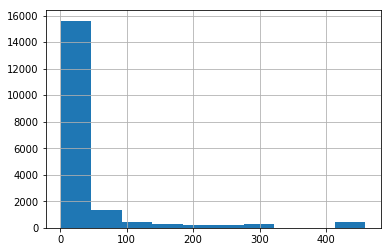

In [115]:
# Proposed decision - combined rescuer counts from training and test
# Originally thought normalisation was required, but since the rescuers 
# are not shared between the training/test data would be irrelevant

# combine all training and test rescuer id counts
rescuer_counts = df_combined['RescuerID'].map(cnt3)

rescuer_counts.hist()

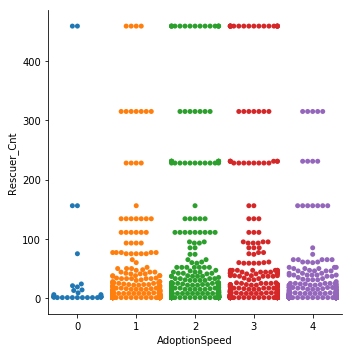

In [166]:
# rescuer counts vs adoption speed
sns_df = pd.DataFrame({'Rescuer_Cnt':   df_train['RescuerID'].map(cnt3),
                       'AdoptionSpeed': df_train['AdoptionSpeed']}).sample(frac=0.1)
sns.catplot( y='Rescuer_Cnt' , x='AdoptionSpeed' , kind='swarm', data=sns_df)

## Functions

In [78]:
def apply_word_flags(df, words):
    """Creates binary columns for words which appear in the description"""
    for word in words:
        df[word] = 0
    for i, desc in df['Description'].items():
        try:
            for word in desc.split():
                word = word.lower()
                if word in words:
                    df.at[i,word] = 1
        except AttributeError:
            continue
    df = df.drop(columns=['Description'])
    return df

In [79]:
keywords = ['home', 'good' , 'adopt', 'loving', 'give', 'looking', 'playful', 'rescued', 'cat', 'contact']

In [80]:
def apply_color_flags(df, colors):
    """Combines Colors 1,2 & 3 into binary columns for each possible colours"""
    for c in colors:
        df[f'C{c}'] = 0
    for i,colors in df[['Color1', 'Color2', 'Color3']].iterrows():
        for c in colors:
            if c != 0:
                df.at[i,f'C{c}'] = 1
    df = df.drop(columns=['Color1', 'Color2', 'Color3'])
    return df

In [81]:
def apply_breed_flags(df, breeds):
    """Combines Breeds 1 & 2 into binary columns for each possible breed"""
    for b in breeds:
        df[f'B{b}'] = 0
    for i,breeds in df[['Breed1', 'Breed2']].iterrows():
        for b in breeds:
            if b != 0:
                df.at[i,f'B{b}'] = 1
    df = df.drop(columns=['Breed1', 'Breed2'])
    return df

## Preparing training data

In [118]:
# Combine test and training data
df_combined = pd.concat([df_test, df_train], sort=False)
df_combined['test'] = df_combined['AdoptionSpeed'].isna()

# Prepare data for modelling 
df_combined['rescuer_counts'] = rescuer_counts
df_combined = apply_word_flags(df_combined, keywords)
df_combined = apply_color_flags(df_combined, colors)
df_combined = apply_breed_flags(df_combined, breeds)
df_combined = pd.get_dummies(df_combined, columns=['Gender',
                                                   'Vaccinated', 'Dewormed', 'Sterilized', 
                                                   'State'])
y_train_all = df_combined['AdoptionSpeed'][df_combined['test'] != 1]
X_all       = df_combined.drop(columns=['Name', 'RescuerID', 'AdoptionSpeed'])
X_train_all = X_all[X_all['test'] != 1].drop(columns=['test'])
X_test_all  = X_all[X_all['test'] == 1].drop(columns=['test'])

## Test Random Forest model

In [119]:
scores = []

folds = KFold(10, True, rnd).split(X_train_all)

for train_indx, test_indx in folds:
    
    X_train, X_test = X_train_all.iloc[train_indx], X_train_all.iloc[test_indx]
    y_train, y_test = y_train_all.iloc[train_indx], y_train_all.iloc[test_indx]
    
    rfc = RandomForestClassifier(n_estimators=200, random_state=rnd)
    rfc.fit(X_train, y_train)
    prediction = rfc.predict(X_test)
    scores.append(ml_metrics.quadratic_weighted_kappa(rater_a=y_test, rater_b=prediction))
    print(scores[-1])

0.36726132384842003
0.4229168003058722
0.3813478232108235
0.38930368543030025
0.3858676546275305
0.37931871738569223
0.3929510925132469
0.38172877895981316
0.33604146974422133
0.379345493047227


In [120]:
# 0.354 --> 0.381 
np.mean(scores)

0.38160828390731466

# Submitting test data

In [97]:
rfc = RandomForestClassifier(n_estimators=200, random_state=rnd)
rfc.fit(X_train_all, y_train_all)
prediction = rfc.predict(X_test_all)

In [98]:
submission = pd.DataFrame({'AdoptionSpeed': prediction.astype(int)}, index=X_test_all.index)
submission.to_csv("submission.csv", index=True, index_label='PetID', header=['AdoptionSpeed'])